# Swissroads Project: 01 - Feature extraction 

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.

## Aim of this notebook 
The goal of this jupyter notebook is to perform the extraction of a set of high level features for each image in the dataset.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf



First, let's plot one image to see what we are dealing with: 

Image original size:  (256, 256)


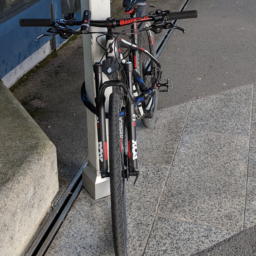

In [7]:
import PIL.Image as Image
import numpy as np

# Load image
img = Image.open('swissroads/train/bike/bike-0001.png')
print('Image original size: ', img.size) # (256, 256)
img 

The image is of size 256 x 256. The pre-trained model that we have chosen expects images of size 299 x 299. We will have to resize our images as follow. 

Batch size: (1, 299, 299, 3)


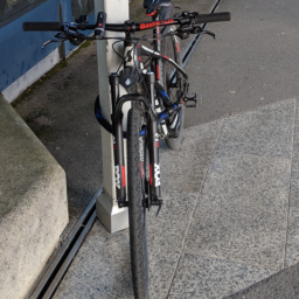

In [9]:
# Create batch for network
img_resized = img.resize([299, 299], resample=Image.BILINEAR) # Expected size
img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch.shape) # (1, 299, 299, 3)

img_resized

The first step for feature extraction is to create the graph that will contain the weigh of the pretrained model. 

In [4]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
    feature_extractor = hub.Module(module_url)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3])

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize() # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


We can now extract and save the pre-trained model's weights: 

In [5]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# Extract features
features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})
features.shape # (1, 2048)

(1, 2048)

In [6]:
features

array([[0.09080733, 0.55624306, 0.0116271 , ..., 0.4014717 , 0.55639553,
        0.31105143]], dtype=float32)

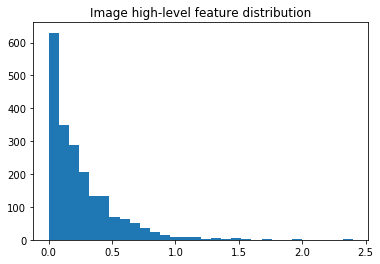

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(features[0], bins=30)
plt.title('Image high-level feature distribution')
plt.show()

As we can see on the figure above, most of the weights are inferior to 1 and close to 0. 
Now that we have saved the weights, we can use them to extract the 2048 most important features in our images in all datasets (train, validation and test): 

In [8]:
# Extract features for train set
import os
from PIL import Image
folder_path = './swissroads/train'

# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)


labels = []
features = []
names = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        # Load image
        file_path = os.path.join(sub_folder_path, filee)
        names += [filee.replace('.png', '')]
        img = Image.open(file_path)

        # Create batch for network
        img_resized = img.resize([299, 299], resample=Image.BILINEAR) # Expected size
        img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
        # Extract features
        features += [sess.run(imgs_features, feed_dict={input_imgs: img_batch})]
        labels += [fldr]

    
    
np.array(features).shape

(280, 1, 2048)

In [9]:
np.array(labels).shape

(280,)

In [10]:
train_X = np.array(features).reshape(-1, 2048)
train_y = np.array(labels)
train_names = np.array(names)

In [11]:
# Extract features for validation set
folder_path = './swissroads/valid'

# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

labels = []
features = []
names = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        # Load image
        file_path = os.path.join(sub_folder_path, filee)
        names += [filee.replace('.png', '')]
        img = Image.open(file_path)

        # Create batch for network
        img_resized = img.resize([299, 299], resample=Image.BILINEAR) # Expected size
        img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
        # Extract features
        features += [sess.run(imgs_features, feed_dict={input_imgs: img_batch})]
        labels += [fldr]

valid_X = np.array(features).reshape(-1, 2048)
valid_y = np.array(labels)
valid_names = np.array(names)

In [12]:
valid_y.shape

(139,)

In [13]:
valid_X.shape

(139, 2048)

In [14]:
# Extract features for test set
folder_path = './swissroads/test'

# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

labels = []
features = []
names = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        # Load image
        file_path = os.path.join(sub_folder_path, filee)
        names += [filee.replace('.png', '')]
        img = Image.open(file_path)

        # Create batch for network
        img_resized = img.resize([299, 299], resample=Image.BILINEAR) # Expected size
        img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
        # Extract features
        features += [sess.run(imgs_features, feed_dict={input_imgs: img_batch})]
        labels += [fldr]

test_X = np.array(features).reshape(-1, 2048)
test_y = np.array(labels)
test_names = np.array(names)

In [15]:
# Save them into a .npz file
np.savez('data/train.npz', features=train_X, targets=train_y, names = train_names)
np.savez('data/valid.npz', features=valid_X, targets=valid_y, names =valid_names)
np.savez('data/test.npz', features=test_X, targets=test_y, names = test_names)

We have extracted and saved the features, together with the classes (target variable) and the names of the images for all datasets in npz files. These features will be used for the remaining tasks. 